In [32]:
import pickle

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
pd.options.display.max_columns = 100
%matplotlib inline

# Bill Info Model
Predict voting behavior largely based off of bill characteristics (type, sunbject, title, etc)
## Feature Construction

In [136]:
# load bills file
df_bills = pd.read_csv('../data/propublica/billsfull_model.csv', encoding = 'latin1')
df_bills.dropna(subset = ['title'], inplace = True)
df_bills.drop_duplicates(subset=['bill_id'], inplace = True)
df_bills.reset_index(drop=True, inplace=True)

# tfidf svd of bill title
tfidf = TfidfVectorizer(encoding='latin1', stop_words = 'english')
df_tfidf = tfidf.fit_transform(df_bills.title)
with open('../data/model/bill_info/tfidf.pickle', 'wb') as f:
    pickle.dump(tfidf, f)    
svd = TruncatedSVD(n_components=100)
df_svd = svd.fit_transform(df_tfidf)
with open('../data/model/bill_info/svd.pickle', 'wb') as f:
    pickle.dump(svd, f)
df_svd = pd.DataFrame(df_svd, index = df_bills.bill_id)
df_svd.columns = ['svd_' + str(x) for x in df_svd.columns]

# get number of actions associated with bill
actions = []
for bill in df_bills.bill_id:
    path = '../data/propublica/model_bills/billinfo_'
    with open(path + bill + '.pickle', 'rb') as f:
        bill_data = pickle.load(f)
    actions.append(len(bill_data['actions']))
df_bills['action_n'] = actions
    
# majority party
df_members = pd.read_csv('../data/propublica/members_all.csv', encoding = 'latin1')
c1 = df_members.short_title == 'Rep.'
c2 = df_members.short_title == 'Sen.'
df_members = df_members[c1 | c2]
df_members.drop_duplicates(subset=['session', 'short_title', 'id' ,'party'], inplace=True)
df_composition = df_members.groupby(['session', 'short_title', 'party']).size().unstack()
df_composition['majority'] = df_composition.apply(lambda x: np.argmax(x), axis = 1)
party_composition = df_composition.to_dict(orient='index')
df_bills.dropna(subset=['sponsor_party'], inplace=True)
def sponsor_majority(row):
    """True if sponsor is in majority party"""
    if row.bill_id[0] == 'h':
        body = 'Rep.'
    else:
        body = 'Sen.'
    majority = party_composition[(row.session, body)]['majority']
    return row.sponsor_party == majority
df_bills['sponsor_is_majority'] = df_bills.apply(sponsor_majority, axis = 1)
def cosponsor_majority(row):
    """do stuff"""
    if row.sponsor_is_majority:
        party_count = row.sponsor_party.lower() + 'sponsor'
        if party_count not in ['rsponsor', 'dsponsor']:
            return 0
        return row[party_count]
    else:
        return 0
    
def cosponsor_minority(row):
    """do stuff"""
    if row.sponsor_is_majority:
        return 0
    else:
        party_count = row.sponsor_party.lower() + 'sponsor'
        if party_count not in ['rsponsor', 'dsponsor']:
            return 0
        return row[party_count]
df_bills['cosponsor_majority'] = df_bills.apply(cosponsor_majority, axis = 1)
df_bills['cosponsor_minority'] = df_bills.apply(cosponsor_minority, axis = 1)

# get bill type
def bill_type(df):
    """Get bill type from bill id"""
    df['bill_type'] = df.bill_id.str.replace('[0-9]', '').str.replace("-", "")
    recode = {"hres": 'res', 'hconres': "conres", 'hjres': 'jres', 
              'sres': 'res', 'sconres':'conres', 'sjres': 'jres', 
              "s":'bill', 'hr': 'bill',
              "": "other", 'motion': "other", 'treatydoc':'other'}
    df['bill_type'] = df.bill_type.replace(recode)
    df = pd.concat([df, pd.get_dummies(df.bill_type, prefix='btype_')], 
                   axis = 1)
    return df
df_bills = bill_type(df_bills)
cols = [x for x in df_bills.columns if x.startswith('btype_')]
cols += ['chamber', 'action_n','cosponsor_majority', 'cosponsor_minority', 'sponsor_is_majority']
df_svd = pd.concat([df_svd, df_bills.set_index('bill_id')[cols]], axis = 1)
df_svd['is_house'] = df_svd.chamber == 'House'
df_svd.drop('chamber', axis = 1, inplace = True)
df_svd.reset_index(inplace = True)
df_svd.rename(columns={'index': 'bill_id'}, inplace = True)

# votes file
def get_full_set(path):
    for dataset in ['train','dev','test']:
        df = pd.read_csv(path + dataset + '.csv', encoding = 'latin1')
        if dataset == 'train':
            df_votes = df
        else:
            df_votes = pd.concat([df_votes, df])
    return df_votes

df_votes = get_full_set('../data/model/')
df_votes = pd.merge(df_votes, df_svd, on = 'bill_id', how = 'left')
df_votes.dropna(subset = ['svd_0'], inplace = True)
cols = [x for x in df_svd.columns if x != 'bill_id']
cols += ['full_set_id']
df_votes = df_votes[cols]
df_votes.to_csv('../data/model/bill_info/features1.csv', index = False)

## Model

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

df_votes = pd.read_csv('../data/model/bill_info/features1.csv')
cols = df_votes.columns.tolist()
features = [x for x in cols if x not in ['full_set_id']]

In [2]:
test = pd.read_csv('../data/model/test.csv')
train = pd.read_csv('../data/model/train.csv')
dev = pd.read_csv('../data/model/dev.csv')
dfs = [train, dev, test]
def join_features(df):
    df = pd.merge(df, df_votes, on = 'full_set_id', how = 'left').dropna(subset = ['svd_0', 'sponsor_is_majority'])
    return df
model_train, model_dev, model_test =  map(join_features, dfs)

In [155]:
# baseline if randomly assign 1 at level proportional to overall rate
t = [1] * int(len(model_dev) * model_train.broke_from_party.mean())
t += ([0] *(len(model_dev) - len(t)))
t = shuffle(t)
print(metrics.classification_report(model_dev['broke_from_party'], t, digits=4))

             precision    recall  f1-score   support

          0     0.9467    0.9461    0.9464    467281
          1     0.0539    0.0544    0.0542     26337

avg / total     0.8990    0.8985    0.8988    493618



In [156]:
features = [x for x in cols if x not in ['full_set_id']]
rfc = RandomForestClassifier(class_weight='balanced', min_samples_split=200)
rfc.fit(model_train[features], model_train['broke_from_party'])
model_dev[features].head(1)

,svd_0,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,svd_11,svd_12,svd_13,svd_14,svd_15,svd_16,svd_17,svd_18,svd_19,svd_20,svd_21,svd_22,svd_23,svd_24,svd_25,svd_26,svd_27,svd_28,svd_29,svd_30,svd_31,svd_32,svd_33,svd_34,svd_35,svd_36,svd_37,svd_38,svd_39,svd_40,svd_41,svd_42,svd_43,svd_44,svd_45,svd_46,svd_47,svd_48,svd_49,...,svd_59,svd_60,svd_61,svd_62,svd_63,svd_64,svd_65,svd_66,svd_67,svd_68,svd_69,svd_70,svd_71,svd_72,svd_73,svd_74,svd_75,svd_76,svd_77,svd_78,svd_79,svd_80,svd_81,svd_82,svd_83,svd_84,svd_85,svd_86,svd_87,svd_88,svd_89,svd_90,svd_91,svd_92,svd_93,svd_94,svd_95,svd_96,svd_97,svd_98,svd_99,btype__bill,btype__conres,btype__jres,btype__res,action_n,cosponsor_majority,cosponsor_minority,sponsor_is_majority,is_house
0,0.025786,0.054664,-0.018617,-0.040118,0.108689,0.031414,-0.106792,-0.019413,0.027626,-0.013142,0.058677,0.058514,-0.072788,0.039451,-0.060278,-0.036376,-0.060594,-0.036023,0.065962,0.005868,-0.014589,-0.004495,-0.009367,0.00548,-0.064787,-0.029069,-0.074154,-0.046341,-0.105401,0.165238,0.079622,-0.048589,-0.07319,-0.045558,0.032129,0.026509,-0.060874,0.039259,-0.026401,-0.020986,-0.084829,-0.059486,-0.01818,-0.018143,-0.012262,0.021235,0.000652,0.040306,0.039241,0.015596,...,0.002746,0.00676,0.009002,-0.018469,0.063563,0.012929,-0.015708,-0.004448,0.016707,0.002097,0.034318,-0.019108,-0.006239,-0.010194,0.018559,-0.025028,-0.014971,0.008336,-0.008921,0.01343,0.013084,0.034728,-0.005828,0.002625,-0.028887,0.005619,0.028642,0.030197,0.014005,-0.027302,-0.009392,0.000537,0.00137,-0.011789,0.018525,0.028301,0.008405,0.01828,-0.020069,0.010032,-0.002156,1.0,0.0,0.0,0.0,0.0,0.0,1.0,False,True


C:\Users\Steve\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


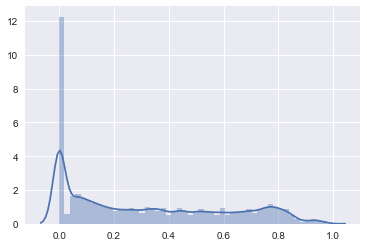

In [157]:
probs_dev = rfc.predict_proba(model_dev[features])[:,1]
probs_train = rfc.predict_proba(model_train[features])[:,1]
sns.distplot(probs_dev)

In [162]:
thresh = .81
print((probs_dev >= thresh).sum())
print(metrics.classification_report(model_dev['broke_from_party'], probs_dev >= thresh, digits=4))

28723
             precision    recall  f1-score   support

          0     0.9610    0.9560    0.9585    467281
          1     0.2849    0.3107    0.2973     26337

avg / total     0.9249    0.9216    0.9232    493618



In [163]:
def export_predictions(dfs, model, file_name, 
                       path = "../data/model/model_predictions/", 
                       predictors = features):
    """Exports probabilities for all sets
    Args:
        dfs: train, dev, test sets. in that order.
        model: sklearn model to get predictions
        path: where to export
        predictors: Column set to use as predictors
    """
    labels = ['train', 'dev', 'test']
    for label, df in zip(labels, dfs):
        probs = model.predict_proba(df[predictors])[:,1]
        probs = pd.DataFrame(probs, index = df.full_set_id, columns=['pred_probs'])
        probs.to_csv(path + file_name + "_" + label + ".csv")

with open('../data/model/bill_info/rfc_bill_info.pickle', 'wb') as f:
    pickle.dump(rfc, f)
dfs = [model_train, model_dev, model_test]
export_predictions(dfs, rfc, 'bill_info', predictors=features)

### GridSearch

In [3]:
param_grid = {'n_estimators': [50, 100, 150],
              'max_features':  ['auto', 'log2', .5],
              'min_samples_split': [100, 200, 300],
              'max_depth': [None, 5, 10],
              'criterion': ["gini", "entropy"]
              }
rfc = RandomForestClassifier(n_jobs=-1, oob_score=True)
cv_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, scoring = 'f1', verbose = 2)
cv_rfc.fit(model_train[features], model_train['broke_from_party'])
print(cv_rfc.best_params_)
rfc = RandomForestClassifier(n_jobs=2, oob_score=True, **cv_rfc.best_params_)
rfc.fit(model_train[features], model_train['broke_from_party'])

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=50 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=50, total= 1.8min
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.9min remaining:    0.0s


[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=50, total= 1.8min
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=50 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=50, total= 1.7min
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=100 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=100, total= 3.4min
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=100 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=100, total= 3.4min
[CV] criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=100 
[CV]  criterion=gini, max_depth=None, max_features=auto, min_samples_split=100, n_estimators=100, total= 3.3min
[CV] criterion=gini, max_depth=None, max_features=auto,

C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=50, total=  41.2s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=50 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=50, total=  39.9s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=100, total= 1.2min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=100, total= 1.2min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=100 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=100, total= 1.2min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=150 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=150, total= 1.8min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=150 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=150, total= 1.8min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=100, n_estimators=150, total= 1.7min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=50 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=50, total=  42.1s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=50 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=50, total=  41.4s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=50 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=50, total=  39.7s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=100, total= 1.2min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=100, total= 1.2min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=100 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=100, total= 1.2min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=150, total= 1.8min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=150 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=150, total= 1.8min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=150 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=200, n_estimators=150, total= 1.7min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=50 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=50, total=  42.0s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=50 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=50, total=  41.9s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estim

C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=50, total=  40.7s
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=100, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=100 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=100, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=100, total= 1.2min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=150 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=150, total= 1.8min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=150 
[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=150, total= 1.8min
[CV] criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=auto, min_samples_split=300, n_estimators=150, total= 1.7min
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=50 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=50, total=  32.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=50 
[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=50, total=  32.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=50 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=50, total=  30.7s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=100, total=  56.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=100, total=  56.6s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=100, total=  53.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=100, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=50 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=50, total=  32.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=50 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=50, total=  32.0s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=50 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=50, total=  30.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=100, total=  56.6s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=100, total=  57.0s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=100, total=  53.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=200, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=50 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=50, total=  32.3s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=50 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=50, total=  32.2s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=50 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=50, total=  30.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=100, total=  56.5s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=100, total=  56.7s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=100 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=100, total=  53.4s
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=150, total= 1.4min
[CV] criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=150 


C:\Users\Steve\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[CV]  criterion=gini, max_depth=5, max_features=log2, min_samples_split=300, n_estimators=150, total= 1.3min
[CV] criterion=gini, max_depth=5, max_features=0.5, min_samples_split=100, n_estimators=50 
[CV]  criterion=gini, max_depth=5, max_features=0.5, min_samples_split=100, n_estimators=50, total= 2.4min
[CV] criterion=gini, max_depth=5, max_features=0.5, min_samples_split=100, n_estimators=50 
[CV]  criterion=gini, max_depth=5, max_features=0.5, min_samples_split=100, n_estimators=50, total= 2.4min
[CV] criterion=gini, max_depth=5, max_features=0.5, min_samples_split=100, n_estimators=50 
[CV]  criterion=gini, max_depth=5, max_features=0.5, min_samples_split=100, n_estimators=50, total= 2.3min
[CV] criterion=gini, max_depth=5, max_features=0.5, min_samples_split=100, n_estimators=100 
[CV]  criterion=gini, max_depth=5, max_features=0.5, min_samples_split=100, n_estimators=100, total= 4.5min
[CV] criterion=gini, max_depth=5, max_features=0.5, min_samples_split=100, n_estimators=100 


KeyboardInterrupt: 